# Stigma against Opioid Use Disorder varies by Personal Use status

```{margin} 
**To follow the full analysis, click through the hidden analysis code below**
```

In [503]:
%matplotlib inline

In [504]:
# import packages
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import pyreadstat
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from utils import *
from samplics.estimation import TaylorEstimator
pd.set_option('mode.chained_assignment', None)

### Data cleaning/pre-processing

In [505]:
# inputs
STATE_ABBREVIATIONS = "state_abbrev_mappings.json"
DATAPATH = "P:/3652/Common/HEAL/y3-task-c-collaborative-projects/jcoin-stigma/analyses/data/protocol2/"
DATA_FILE = DATAPATH+"3645_JCOIN_HEAL Initiative 2021_NORC_Jan2022_1.sav"
STRATA_FILE = DATAPATH+"VSTRAT_VPSU_Survey_2039_HEAL_MAIN_21_05_14.csv"

In [506]:
# import data and metadata (data dictionaries)
df, meta = pyreadstat.read_sav(DATA_FILE,apply_value_formats=True)


In [507]:

# lower-case column names 
df.columns = df.columns.str.lower()

In [508]:
vars_of_interest = ["caseid",'p_over','weight1','weight2','stigma_scale_score','expanded_10item_stigma','state','age4','racethnicity','educ5','personaluse_ever','familyuse_ever','personalcrimjust_ever','familycrimjust_ever']
categorical_vars = ['p_over','state','age4','racethnicity','educ5',
    'personaluse_ever','familyuse_ever',
    'personalcrimjust_ever','familycrimjust_ever']



In [509]:
# to enable more granular analysis of the stigma scale score(s) - e.g. parsing impact of current versus past OUD on stigma - bring in the individual ss questions

# ss_a_historywork - agree means low stigma/high val means low stigma
# ss_b_historymarry - agree means low stigma/high val means low stigma
# ss_c_currentwork - agree means low stigma/high val means low stigma
# ss_d_currentmarry - agree means low stigma/high val means low stigma

# -------- use the reverse coded for history and current work and marry vars - these ones are the only ss questions where agree means low stigma, using the reverse coded version brings them in line with the others for easier analysis

# ss_a_historywork_rev - already converted to numeric/high val means high stigma
# ss_b_historymarry_rev - already converted to numeric/high val means high stigma
# ss_c_currentwork_rev - already converted to numeric/high val means high stigma
# ss_d_currentmarry_rev - already converted to numeric/high val means high stigma

# ss_e_dangerous - agree means high stigma/high val means high stigma
# ss_f_ trust - agree means high stigma/high val means high stigma
# ss_history_steal - agree means high stigma/high val means high stigma
# ss_historyhighrisk - agree means high stigma/high val means high stigma
# ss_currentsteal - agree means high stigma/high val means high stigma
# ss_currenthighrisk - agree means high stigma/high val means high stigma

ss_6_past = ['ss_a_historywork_rev','ss_b_historymarry_rev']
ss_6_current = ['ss_c_currentwork_rev','ss_d_currentmarry_rev','ss_e_dangerous','ss_f_trust']

ss_6_full = ss_6_past + ss_6_current

ss_10_past = ['ss_historysteal', 'ss_historyhighrisk']
ss_10_current = ['ss_currentsteal', 'ss_currenthighrisk']

ss_10_full = ss_6_full + ss_10_past + ss_10_current

ss_past = ss_6_past + ss_10_past
ss_current = ss_6_current + ss_10_current





In [510]:
# to enable parsing of stigma by political affiliation, views on race/ethnicity, and experience of racial/ethnic discrimination bring in variables assessing those items

# political = ['pid1','pida','pidb','pidi','partyid7','partyid5']
political = ['partyid5']

race = ['race_whiteadvantage','race_rich']

# race_whiteadvanctage: [White people in the U.S. have certain advantages because of the color of their skin.] Do you disagree or agree with the following statements?
    # agree corresponds with recognition of white advantage; high vals = recognition of white advantage
    # reverse code this from likert vars so that high vals will now indicate lack of recognition of white advantage

# race_rich: [Everyone who works hard, no matter what race they are, has an equal chance to become rich.] Do you disagree or agree with the following statements?
    # agree corresponds with lack of recognition of white advantage; high vals = lack of recognition of white advantage
    # code this along with the likert vars where high vals = high stigma; in this case high vals = lack of recognition of white advantage

#discrimination_experience = ['times_atschool', 'times_hired', 'times_atwork', 'times_housing', 'times_medcare', 'times_restaurant', 'times_credit', 'times_street', 'times_police']

# possible approach: 
    # add count of dicrimination experiences (times) across categories
    # higher numbers mean more discrimination experience



In [511]:
likert_replace_vars = ['ss_e_dangerous','ss_f_trust','ss_historysteal', 'ss_historyhighrisk','ss_currentsteal', 'ss_currenthighrisk','race_rich']
likert_reverse_replace_vars = ['race_whiteadvantage']

In [512]:

#additional_vars_of_interest = ss_10_full + political + race + discrimination_experience
additional_vars_of_interest = ["caseid"] + ss_10_full + political + race 
all_vars_of_interest = vars_of_interest + additional_vars_of_interest



In [513]:
# narrow down the dataset to only a few interesting (and relatively clean, straightforward variables) - check for missingness and impute to fill in missing
sub_df_1 = df[vars_of_interest]
sub_df_2 = df[additional_vars_of_interest]

In [514]:
sub_df_2

,caseid,ss_a_historywork_rev,ss_b_historymarry_rev,ss_c_currentwork_rev,ss_d_currentmarry_rev,ss_e_dangerous,ss_f_trust,ss_historysteal,ss_historyhighrisk,ss_currentsteal,ss_currenthighrisk,partyid5,race_whiteadvantage,race_rich
0,55.0,3.0,4.0,4.0,5.0,Strongly agree,Somewhat agree,Somewhat disagree,Neither disagree nor agree,Strongly agree,Somewhat agree,Democrat,Somewhat agree,Neither disagree nor agree
1,59.0,4.0,3.0,5.0,4.0,Somewhat agree,Neither disagree nor agree,Somewhat disagree,Strongly agree,Somewhat agree,Strongly agree,Republican,Somewhat agree,Somewhat agree
2,60.0,2.0,2.0,4.0,4.0,Somewhat disagree,Neither disagree nor agree,Somewhat disagree,Somewhat disagree,Neither disagree nor agree,Somewhat agree,Republican,Somewhat disagree,Somewhat disagree
3,61.0,2.0,3.0,5.0,5.0,Somewhat agree,Somewhat agree,Neither disagree nor agree,Neither disagree nor agree,Strongly agree,Strongly agree,Republican,Somewhat disagree,Strongly agree
4,62.0,2.0,3.0,3.0,5.0,Neither disagree nor agree,Strongly disagree,Strongly disagree,Strongly disagree,Somewhat agree,Somewhat agree,Lean Democrat,Strongly disagree,Strongly agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,17115.0,2.0,2.0,4.0,4.0,Strongly agree,Strongly agree,Neither disagree nor agree,Somewhat agree,Strongly agree,Strongly agree,Republican,Strongly disagree,Strongly agree
6511,17116.0,4.0,2.0,5.0,4.0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree,Strongly agree,Strongly agree,Democrat,Somewhat agree,Somewhat agree
6512,17117.0,3.0,5.0,3.0,5.0,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Democrat,Somewhat agree,Somewhat agree
6513,17118.0,2.0,1.0,2.0,4.0,Somewhat disagree,Somewhat agree,Somewhat agree,Somewhat disagree,Neither disagree nor agree,Neither disagree nor agree,Democrat,Neither disagree nor agree,Somewhat disagree


In [515]:
# get all var types
print("var info: ")
print(sub_df_2.info())

# all new vars (except the reverse coded individual stigma scale questions) are categorical

var info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   caseid                 6515 non-null   float64 
 1   ss_a_historywork_rev   6471 non-null   float64 
 2   ss_b_historymarry_rev  6459 non-null   float64 
 3   ss_c_currentwork_rev   6476 non-null   float64 
 4   ss_d_currentmarry_rev  6468 non-null   float64 
 5   ss_e_dangerous         6459 non-null   category
 6   ss_f_trust             6486 non-null   category
 7   ss_historysteal        6480 non-null   category
 8   ss_historyhighrisk     6485 non-null   category
 9   ss_currentsteal        6478 non-null   category
 10  ss_currenthighrisk     6481 non-null   category
 11  partyid5               6483 non-null   category
 12  race_whiteadvantage    6471 non-null   category
 13  race_rich              6481 non-null   category
dtypes: category(9), float64(5)
me

In [516]:
# check for missing I

# check if missing values
print("missing values: ")
print(sub_df_2.isnull().sum())

# check if missing values
print("missing values: ")
print(sub_df_2.isna().sum())

# every var has at least some missing, except for partyid7

missing values: 
caseid                    0
ss_a_historywork_rev     44
ss_b_historymarry_rev    56
ss_c_currentwork_rev     39
ss_d_currentmarry_rev    47
ss_e_dangerous           56
ss_f_trust               29
ss_historysteal          35
ss_historyhighrisk       30
ss_currentsteal          37
ss_currenthighrisk       34
partyid5                 32
race_whiteadvantage      44
race_rich                34
dtype: int64
missing values: 
caseid                    0
ss_a_historywork_rev     44
ss_b_historymarry_rev    56
ss_c_currentwork_rev     39
ss_d_currentmarry_rev    47
ss_e_dangerous           56
ss_f_trust               29
ss_historysteal          35
ss_historyhighrisk       30
ss_currentsteal          37
ss_currenthighrisk       34
partyid5                 32
race_whiteadvantage      44
race_rich                34
dtype: int64


In [517]:
#print("ss single questions, categories: ")
#print(sub_df_2.ss_a_historywork.value_counts(dropna=False))

print("ss single questions, categories: ")
print(sub_df_2.ss_a_historywork_rev.value_counts(dropna=False))

print("ss single questions, categories: ")
print(sub_df_2.ss_e_dangerous.value_counts(dropna=False))

#print("party id 7 composite question, categories: ")
#print(sub_df_2.partyid7.value_counts(dropna=False))

print("party id 5 composite question, categories: ")
print(sub_df_2.partyid5.value_counts(dropna=False))

#print("discrimination times single questions, categories: ")
#print(sub_df_2.times_atschool.value_counts(dropna=False))

ss single questions, categories: 
2.0    2832
3.0    1481
1.0    1420
4.0     517
5.0     221
NaN      44
Name: ss_a_historywork_rev, dtype: int64
ss single questions, categories: 
Somewhat agree                2179
Neither disagree nor agree    2078
Somewhat disagree              981
Strongly agree                 811
Strongly disagree              410
NaN                             56
Name: ss_e_dangerous, dtype: int64
party id 5 composite question, categories: 
Democrat                       2466
Republican                     1548
Don't Lean/Independent/None     984
Lean Democrat                   796
Lean Republican                 689
NaN                              32
Name: partyid5, dtype: int64


In [518]:
likert_replacer = {'Strongly disagree': 1, 
                   'Somewhat disagree': 2,
                   'Neither disagree nor agree': 3,
                   'Somewhat agree': 4, 
                   'Strongly agree': 5}

likert_reverse_replacer = {'Strongly disagree': 5, 
                           'Somewhat disagree': 4,
                           'Neither disagree nor agree': 3,
                           'Somewhat agree': 2, 
                           'Strongly agree': 1}

sub_df_2[likert_replace_vars].replace(likert_replacer, inplace=True)
sub_df_2[likert_replace_vars] = sub_df_2[likert_replace_vars].astype("float")

sub_df_2[likert_reverse_replace_vars].replace(likert_reverse_replacer, inplace=True)
sub_df_2[likert_reverse_replace_vars] = sub_df_2[likert_reverse_replace_vars].astype("float")

#sub_df_2['partyid5_any_d'] = np.where(sub_df_2['partyid5'] in ["Democrat","Lean Democrat"], 1,0)
sub_df_2['partyid5_strong_d'] = np.where(sub_df_2['partyid5'] == "Democrat", 1,0)
#sub_df_2['partyid5_any_r'] = np.where(sub_df_2['partyid5'] in ["Republican","Lean Republican"], 1,0)
sub_df_2['partyid5_strong_r'] = np.where(sub_df_2['partyid5'] == "Republican", 1,0)

sub_df_2.drop(['partyid5'], axis=1, inplace=True)

sub_df_2



,caseid,ss_a_historywork_rev,ss_b_historymarry_rev,ss_c_currentwork_rev,ss_d_currentmarry_rev,ss_e_dangerous,ss_f_trust,ss_historysteal,ss_historyhighrisk,ss_currentsteal,ss_currenthighrisk,race_whiteadvantage,race_rich,partyid5_strong_d,partyid5_strong_r
0,55.0,3.0,4.0,4.0,5.0,5.0,4.0,2.0,3.0,5.0,4.0,2.0,3.0,1,0
1,59.0,4.0,3.0,5.0,4.0,4.0,3.0,2.0,5.0,4.0,5.0,2.0,4.0,0,1
2,60.0,2.0,2.0,4.0,4.0,2.0,3.0,2.0,2.0,3.0,4.0,4.0,2.0,0,1
3,61.0,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,5.0,5.0,4.0,5.0,0,1
4,62.0,2.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0,4.0,4.0,5.0,5.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,17115.0,2.0,2.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0,5.0,5.0,5.0,0,1
6511,17116.0,4.0,2.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,2.0,4.0,1,0
6512,17117.0,3.0,5.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,1,0
6513,17118.0,2.0,1.0,2.0,4.0,2.0,4.0,4.0,2.0,3.0,3.0,3.0,2.0,1,0


In [519]:
# check for missing I

# check if missing values
print("missing values: ")
print(sub_df_2.isnull().sum())

# check if missing values
print("missing values: ")
print(sub_df_2.isna().sum())

missing values: 
caseid                    0
ss_a_historywork_rev     44
ss_b_historymarry_rev    56
ss_c_currentwork_rev     39
ss_d_currentmarry_rev    47
ss_e_dangerous           56
ss_f_trust               29
ss_historysteal          35
ss_historyhighrisk       30
ss_currentsteal          37
ss_currenthighrisk       34
race_whiteadvantage      44
race_rich                34
partyid5_strong_d         0
partyid5_strong_r         0
dtype: int64
missing values: 
caseid                    0
ss_a_historywork_rev     44
ss_b_historymarry_rev    56
ss_c_currentwork_rev     39
ss_d_currentmarry_rev    47
ss_e_dangerous           56
ss_f_trust               29
ss_historysteal          35
ss_historyhighrisk       30
ss_currentsteal          37
ss_currenthighrisk       34
race_whiteadvantage      44
race_rich                34
partyid5_strong_d         0
partyid5_strong_r         0
dtype: int64


In [520]:
# get all var types
print("var info: ")
print(sub_df_2.info())

var info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   caseid                 6515 non-null   float64
 1   ss_a_historywork_rev   6471 non-null   float64
 2   ss_b_historymarry_rev  6459 non-null   float64
 3   ss_c_currentwork_rev   6476 non-null   float64
 4   ss_d_currentmarry_rev  6468 non-null   float64
 5   ss_e_dangerous         6459 non-null   float64
 6   ss_f_trust             6486 non-null   float64
 7   ss_historysteal        6480 non-null   float64
 8   ss_historyhighrisk     6485 non-null   float64
 9   ss_currentsteal        6478 non-null   float64
 10  ss_currenthighrisk     6481 non-null   float64
 11  race_whiteadvantage    6471 non-null   float64
 12  race_rich              6481 non-null   float64
 13  partyid5_strong_d      6515 non-null   int32  
 14  partyid5_strong_r      6515 non-null   int32 

In [521]:
mode_impute_vars = ss_10_full + race
mode_impute_vars


['ss_a_historywork_rev',
 'ss_b_historymarry_rev',
 'ss_c_currentwork_rev',
 'ss_d_currentmarry_rev',
 'ss_e_dangerous',
 'ss_f_trust',
 'ss_historysteal',
 'ss_historyhighrisk',
 'ss_currentsteal',
 'ss_currenthighrisk',
 'race_whiteadvantage',
 'race_rich']

In [522]:


#df['salary'] = df['salary'].fillna(df['salary'].mode()[0])

sub_df_2[mode_impute_vars] = sub_df_2[mode_impute_vars].fillna(sub_df_2[mode_impute_vars].mode().iloc[0])

# check if missing values
print("missing values: ")
print(sub_df_2.isnull().sum())

missing values: 
caseid                   0
ss_a_historywork_rev     0
ss_b_historymarry_rev    0
ss_c_currentwork_rev     0
ss_d_currentmarry_rev    0
ss_e_dangerous           0
ss_f_trust               0
ss_historysteal          0
ss_historyhighrisk       0
ss_currentsteal          0
ss_currenthighrisk       0
race_whiteadvantage      0
race_rich                0
partyid5_strong_d        0
partyid5_strong_r        0
dtype: int64


In [523]:
# get all var types
print("var info: ")
print(sub_df_2.info())

var info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   caseid                 6515 non-null   float64
 1   ss_a_historywork_rev   6515 non-null   float64
 2   ss_b_historymarry_rev  6515 non-null   float64
 3   ss_c_currentwork_rev   6515 non-null   float64
 4   ss_d_currentmarry_rev  6515 non-null   float64
 5   ss_e_dangerous         6515 non-null   float64
 6   ss_f_trust             6515 non-null   float64
 7   ss_historysteal        6515 non-null   float64
 8   ss_historyhighrisk     6515 non-null   float64
 9   ss_currentsteal        6515 non-null   float64
 10  ss_currenthighrisk     6515 non-null   float64
 11  race_whiteadvantage    6515 non-null   float64
 12  race_rich              6515 non-null   float64
 13  partyid5_strong_d      6515 non-null   int32  
 14  partyid5_strong_r      6515 non-null   int32 

In [524]:
#df['avg'] = df[['Monday', 'Tuesday']].mean(axis=1)

sub_df_2["ss_6_past"] = sub_df_2[ss_6_past].mean(axis=1)
sub_df_2["ss_6_current"] = sub_df_2[ss_6_current].mean(axis=1)

sub_df_2["ss_past"] = sub_df_2[ss_past].mean(axis=1)
sub_df_2["ss_current"] = sub_df_2[ss_current].mean(axis=1)

flag_threshold = 3

sub_df_2["race_view_flag"] = np.where((sub_df_2["race_whiteadvantage"] > flag_threshold) | (sub_df_2["race_rich"] > flag_threshold), 1, 0)

In [525]:
# get all var types
print("var info: ")
print(sub_df_2.info())

var info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   caseid                 6515 non-null   float64
 1   ss_a_historywork_rev   6515 non-null   float64
 2   ss_b_historymarry_rev  6515 non-null   float64
 3   ss_c_currentwork_rev   6515 non-null   float64
 4   ss_d_currentmarry_rev  6515 non-null   float64
 5   ss_e_dangerous         6515 non-null   float64
 6   ss_f_trust             6515 non-null   float64
 7   ss_historysteal        6515 non-null   float64
 8   ss_historyhighrisk     6515 non-null   float64
 9   ss_currentsteal        6515 non-null   float64
 10  ss_currenthighrisk     6515 non-null   float64
 11  race_whiteadvantage    6515 non-null   float64
 12  race_rich              6515 non-null   float64
 13  partyid5_strong_d      6515 non-null   int32  
 14  partyid5_strong_r      6515 non-null   int32 

In [526]:
# clean up some of the categoricals to be consistently coded
sub_df_1.familycrimjust_ever.replace({0:"No",1:"Yes"},inplace=True)
sub_df_1.familyuse_ever.replace({" No":"No"},inplace=True)
sub_df_1.personalcrimjust_ever.replace({"Yes, ever arrested or incarcerated":"Yes", "No, never arrested or incarcerated":"No"},inplace=True)


In [527]:
# check for missing 

print(sub_df_1.isnull().sum())


caseid                       0
p_over                       0
weight1                   5331
weight2                      0
stigma_scale_score           5
expanded_10item_stigma       5
state                        0
age4                         0
racethnicity                 0
educ5                        0
personaluse_ever            28
familyuse_ever              25
personalcrimjust_ever       28
familycrimjust_ever         51
dtype: int64


In [528]:

# impute any missing - confirm missing eliminated

# # impute missing stigma scale score vals with median, impute missing personaluse_ever with mode, "No"

# replace missing values of personaluse_ever with mode value of 'No'
sub_df_1.personaluse_ever.fillna('No',inplace=True)
#print(sub_df_1.isnull().sum())

sub_df_1.familyuse_ever.fillna('No',inplace=True)
#print(sub_df_1.isnull().sum())

sub_df_1.personalcrimjust_ever.fillna('No',inplace=True)
#print(sub_df_1.isnull().sum())

sub_df_1.familycrimjust_ever.fillna('No',inplace=True)
#print(sub_df_1.isnull().sum())


# impute missing stigma scale score values as the median score 
#sub_df_1['stigma_scale_score'].fillna(sub_df_1.groupby('time-point')['stigma_scale_score'].transform('median'),inplace=True)
sub_df_1['stigma_scale_score'].fillna(sub_df_1['stigma_scale_score'].median(),inplace=True)
sub_df_1['expanded_10item_stigma'].fillna(sub_df_1['expanded_10item_stigma'].median(),inplace=True)

print(sub_df_1.isnull().sum())

caseid                       0
p_over                       0
weight1                   5331
weight2                      0
stigma_scale_score           0
expanded_10item_stigma       0
state                        0
age4                         0
racethnicity                 0
educ5                        0
personaluse_ever             0
familyuse_ever               0
personalcrimjust_ever        0
familycrimjust_ever          0
dtype: int64


In [529]:
# add df column with state 2 letter code
# https://pythonfix.com/code/us-states-abbrev.py/
# state name to two letter code dictionary
us_state_to_abbrev = json.loads(Path(STATE_ABBREVIATIONS).read_text())
state_cd = sub_df_1.state.replace(us_state_to_abbrev)
sub_df_1.insert(6,"state_cd",state_cd,True)

In [530]:
# Add jcoin information
jcoin_json = json.loads(Path("jcoin_states.json").read_text())

jcoin_df = (pd.DataFrame(jcoin_json)
    .assign(hub_types=lambda df:df["hub"]+"("+df["type"]+")")
    .groupby('states')
    # make a list of the name and type of hub/study and how many hubs are in that state
    .agg({"hub_types":lambda s:",".join(s),"hub":"count"})
    .reset_index()
    .rename(
        columns={"states":"state_cd",
        "hub":"jcoin_hub_count",
        "hub_types":"jcoin_hub_types"})
)

jcoin_df["jcoin_flag"] = 1

In [531]:
jcoin_df.head()

,state_cd,jcoin_hub_types,jcoin_hub_count,jcoin_flag
0,CT,"NYU(MOUD comparative effectiveness),Yale - TCN...",2,1
1,DE,NYU(MOUD comparative effectiveness),1,1
2,IL,"Chestnut(Linkage),U Chicago - ROMI(Linkage)",2,1
3,IN,Indiana(Linkage),1,1
4,KY,UKY(Linkage),1,1


In [532]:
sub_df_1 = sub_df_1.merge(jcoin_df,on="state_cd",how="left")
sub_df_1["jcoin_hub_types"].fillna("not JCOIN",inplace=True)
sub_df_1["jcoin_hub_count"].fillna(0,inplace=True)
sub_df_1["jcoin_flag"].fillna(0,inplace=True)
sub_df_1["is_jcoin_hub"] = np.where(sub_df_1["jcoin_hub_types"]=="not JCOIN","No","Yes")
sub_df_1.head()

,caseid,p_over,weight1,weight2,stigma_scale_score,expanded_10item_stigma,state_cd,state,age4,racethnicity,educ5,personaluse_ever,familyuse_ever,personalcrimjust_ever,familycrimjust_ever,jcoin_hub_types,jcoin_hub_count,jcoin_flag,is_jcoin_hub
0,55.0,AS oversample,NaN,0.540552,4.166667,3.9,IL,Illinois,45-59,"White, non-Hispanic",Vocational/tech school/some college/ associates,No,Yes,No,Yes,"Chestnut(Linkage),U Chicago - ROMI(Linkage)",2.0,1.0,Yes
1,59.0,AS oversample,NaN,2.283059,3.833333,3.9,TX,Texas,18-29,"White, non-Hispanic",Bachelor's degree,No,Yes,No,No,TCU(Linkage),1.0,1.0,Yes
2,60.0,AS oversample,NaN,0.419725,2.833333,2.8,GA,Georgia,60+,"White, non-Hispanic",Vocational/tech school/some college/ associates,No,No,No,No,not JCOIN,0.0,0.0,No
3,61.0,Gen pop,1.632304,1.407076,3.833333,3.9,NY,New York,45-59,"White, non-Hispanic",Vocational/tech school/some college/ associates,No,Yes,No,Yes,"State of New York/NYSPI(State policy rollout),...",3.0,1.0,Yes
4,62.0,AS oversample,NaN,1.515253,2.833333,2.7,PA,Pennsylvania,30-44,"White, non-Hispanic",HS graduate or equivalent,No,No,No,No,Brown(Linkage),1.0,1.0,Yes


In [533]:
# join strata into dataset
sub_df_1 = sub_df_1.merge(sub_df_2,on='caseid',how='left')


sub_df_1

,caseid,p_over,weight1,weight2,stigma_scale_score,expanded_10item_stigma,state_cd,state,age4,racethnicity,...,ss_currenthighrisk,race_whiteadvantage,race_rich,partyid5_strong_d,partyid5_strong_r,ss_6_past,ss_6_current,ss_past,ss_current,race_view_flag
0,55.0,AS oversample,NaN,0.540552,4.166667,3.9,IL,Illinois,45-59,"White, non-Hispanic",...,4.0,2.0,3.0,1,0,3.5,4.50,3.00,4.500000,0
1,59.0,AS oversample,NaN,2.283059,3.833333,3.9,TX,Texas,18-29,"White, non-Hispanic",...,5.0,2.0,4.0,0,1,3.5,4.00,3.50,4.166667,1
2,60.0,AS oversample,NaN,0.419725,2.833333,2.8,GA,Georgia,60+,"White, non-Hispanic",...,4.0,4.0,2.0,0,1,2.0,3.25,2.00,3.333333,1
3,61.0,Gen pop,1.632304,1.407076,3.833333,3.9,NY,New York,45-59,"White, non-Hispanic",...,5.0,4.0,5.0,0,1,2.5,4.50,2.75,4.666667,1
4,62.0,AS oversample,NaN,1.515253,2.833333,2.7,PA,Pennsylvania,30-44,"White, non-Hispanic",...,4.0,5.0,5.0,0,0,2.5,3.00,1.75,3.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,17115.0,AS oversample,NaN,1.583457,3.666667,3.9,NM,New Mexico,60+,"White, non-Hispanic",...,5.0,5.0,5.0,0,1,2.0,4.50,2.75,4.666667,1
6511,17116.0,AS oversample,NaN,1.822617,4.166667,4.3,LA,Louisiana,60+,"White, non-Hispanic",...,5.0,2.0,4.0,1,0,3.0,4.75,3.50,4.833333,1
6512,17117.0,AS oversample,NaN,0.027271,4.000000,4.0,MA,Massachusetts,60+,Hispanic,...,4.0,2.0,4.0,1,0,4.0,4.00,4.00,4.000000,1
6513,17118.0,AS oversample,NaN,6.375612,2.500000,2.7,GA,Georgia,18-29,"Black, non-Hispanic",...,3.0,3.0,2.0,1,0,1.5,3.00,2.25,3.000000,0


In [534]:
sub_df_1.columns

Index(['caseid', 'p_over', 'weight1', 'weight2', 'stigma_scale_score',
       'expanded_10item_stigma', 'state_cd', 'state', 'age4', 'racethnicity',
       'educ5', 'personaluse_ever', 'familyuse_ever', 'personalcrimjust_ever',
       'familycrimjust_ever', 'jcoin_hub_types', 'jcoin_hub_count',
       'jcoin_flag', 'is_jcoin_hub', 'ss_a_historywork_rev',
       'ss_b_historymarry_rev', 'ss_c_currentwork_rev',
       'ss_d_currentmarry_rev', 'ss_e_dangerous', 'ss_f_trust',
       'ss_historysteal', 'ss_historyhighrisk', 'ss_currentsteal',
       'ss_currenthighrisk', 'race_whiteadvantage', 'race_rich',
       'partyid5_strong_d', 'partyid5_strong_r', 'ss_6_past', 'ss_6_current',
       'ss_past', 'ss_current', 'race_view_flag'],
      dtype='object')

In [535]:
# o	all: n/weighted n in genpop
# o	all:n/weighted n in as oversample
# o	all:n/weighted n in as oversample + gen pop(in oversampled state)
# o	per state: n/weighted n in as oversample
# o	missingness; imputation procedures

In [536]:
pop_counts_by_sampletypexstate = (
    sub_df_1
    .convert_dtypes()
    .assign(jcoin_hub_count=lambda df: df.jcoin_hub_count.astype(str))
    .groupby(['state_cd','p_over'])
    ["stigma_scale_score"]
    .count()
    .unstack(['p_over'])
)
pop_counts_by_sampletypexstate["total"] = pop_counts_by_sampletypexstate.sum(axis=1)

In [537]:
# merge jcoin info
pop_counts_by_sampletypexstate = pop_counts_by_sampletypexstate\
    .merge(jcoin_df,on='state_cd',how='left')\
    .sort_values("total",ascending=False)\
    .assign(
        jcoin_hub_count=lambda df:df.jcoin_hub_count.fillna(0).astype(int),
        jcoin_flag=lambda df:df.jcoin_flag.fillna(0).astype(int),
        jcoin_hub_types=lambda df:(
            np.where(df.jcoin_hub_types.isna() & df["AS oversample"]>0,"non JCOIN comparison",
                np.where(df.jcoin_hub_types.isna(),"non JCOIN gen pop",df.jcoin_hub_types)
        )
        
        ))

In [538]:
pop_counts_by_sampletypexstate

,state_cd,AS oversample,Gen pop,total,jcoin_hub_types,jcoin_hub_count,jcoin_flag
4,CA,258,119,377,non JCOIN gen pop,0,0
9,FL,234,94,328,non JCOIN gen pop,0,0
43,TX,239,88,327,TCU(Linkage),1,1
15,IN,263,34,297,Indiana(Linkage),1,1
19,MA,263,24,287,Mass/BayState(State policy rollout),1,1
27,NC,244,38,282,"Yale - TCN(Linkage),Brown(Linkage)",2,1
34,NY,230,48,278,"State of New York/NYSPI(State policy rollout),...",3,1
48,WI,232,38,270,non JCOIN gen pop,0,0
23,MN,246,23,269,Yale - TCN(Linkage),1,1
14,IL,208,58,266,"Chestnut(Linkage),U Chicago - ROMI(Linkage)",2,1


In [539]:
states_with_oversample_df = pop_counts_by_sampletypexstate[pop_counts_by_sampletypexstate["AS oversample"] > 0]
states_with_oversample_list = states_with_oversample_df["state_cd"]

print(states_with_oversample_list)
states_with_oversample_df

4     CA
9     FL
43    TX
15    IN
19    MA
27    NC
34    NY
48    WI
23    MN
14    IL
5     CO
10    GA
37    OR
38    PA
45    VA
31    NJ
3     AZ
20    MD
47    WA
17    KY
18    LA
6     CT
32    NM
8     DE
30    NH
11    HI
39    RI
Name: state_cd, dtype: string


,state_cd,AS oversample,Gen pop,total,jcoin_hub_types,jcoin_hub_count,jcoin_flag
4,CA,258,119,377,non JCOIN gen pop,0,0
9,FL,234,94,328,non JCOIN gen pop,0,0
43,TX,239,88,327,TCU(Linkage),1,1
15,IN,263,34,297,Indiana(Linkage),1,1
19,MA,263,24,287,Mass/BayState(State policy rollout),1,1
27,NC,244,38,282,"Yale - TCN(Linkage),Brown(Linkage)",2,1
34,NY,230,48,278,"State of New York/NYSPI(State policy rollout),...",3,1
48,WI,232,38,270,non JCOIN gen pop,0,0
23,MN,246,23,269,Yale - TCN(Linkage),1,1
14,IL,208,58,266,"Chestnut(Linkage),U Chicago - ROMI(Linkage)",2,1


In [540]:
print("N for Oversample, General and Total By State")
pop_counts_by_sampletypexstate.reset_index()

pop_counts_by_sampletypexstate.to_csv("state_counts.csv")


N for Oversample, General and Total By State


In [541]:
print("N All")
pop_counts_by_sampletypexstate.sum().to_frame().T

N All


C:\Users\tentner-andrea\AppData\Local\Temp\ipykernel_46000\1885457482.py:2: FutureWarning:

The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



,AS oversample,Gen pop,total,jcoin_hub_types,jcoin_hub_count,jcoin_flag
0,5331,1184,6515,non JCOIN gen popnon JCOIN gen popTCU(Linkage)...,21,16


In [542]:
# get subset of surveyed people who live in states with an oversample to calculate state level stats

print(sub_df_1.columns)

sub_df_1_as_oversample_states = sub_df_1[sub_df_1["state_cd"].isin(states_with_oversample_list)]

sub_df_1_as_oversample_states

Index(['caseid', 'p_over', 'weight1', 'weight2', 'stigma_scale_score',
       'expanded_10item_stigma', 'state_cd', 'state', 'age4', 'racethnicity',
       'educ5', 'personaluse_ever', 'familyuse_ever', 'personalcrimjust_ever',
       'familycrimjust_ever', 'jcoin_hub_types', 'jcoin_hub_count',
       'jcoin_flag', 'is_jcoin_hub', 'ss_a_historywork_rev',
       'ss_b_historymarry_rev', 'ss_c_currentwork_rev',
       'ss_d_currentmarry_rev', 'ss_e_dangerous', 'ss_f_trust',
       'ss_historysteal', 'ss_historyhighrisk', 'ss_currentsteal',
       'ss_currenthighrisk', 'race_whiteadvantage', 'race_rich',
       'partyid5_strong_d', 'partyid5_strong_r', 'ss_6_past', 'ss_6_current',
       'ss_past', 'ss_current', 'race_view_flag'],
      dtype='object')


,caseid,p_over,weight1,weight2,stigma_scale_score,expanded_10item_stigma,state_cd,state,age4,racethnicity,...,ss_currenthighrisk,race_whiteadvantage,race_rich,partyid5_strong_d,partyid5_strong_r,ss_6_past,ss_6_current,ss_past,ss_current,race_view_flag
0,55.0,AS oversample,NaN,0.540552,4.166667,3.9,IL,Illinois,45-59,"White, non-Hispanic",...,4.0,2.0,3.0,1,0,3.5,4.50,3.00,4.500000,0
1,59.0,AS oversample,NaN,2.283059,3.833333,3.9,TX,Texas,18-29,"White, non-Hispanic",...,5.0,2.0,4.0,0,1,3.5,4.00,3.50,4.166667,1
2,60.0,AS oversample,NaN,0.419725,2.833333,2.8,GA,Georgia,60+,"White, non-Hispanic",...,4.0,4.0,2.0,0,1,2.0,3.25,2.00,3.333333,1
3,61.0,Gen pop,1.632304,1.407076,3.833333,3.9,NY,New York,45-59,"White, non-Hispanic",...,5.0,4.0,5.0,0,1,2.5,4.50,2.75,4.666667,1
4,62.0,AS oversample,NaN,1.515253,2.833333,2.7,PA,Pennsylvania,30-44,"White, non-Hispanic",...,4.0,5.0,5.0,0,0,2.5,3.00,1.75,3.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,17115.0,AS oversample,NaN,1.583457,3.666667,3.9,NM,New Mexico,60+,"White, non-Hispanic",...,5.0,5.0,5.0,0,1,2.0,4.50,2.75,4.666667,1
6511,17116.0,AS oversample,NaN,1.822617,4.166667,4.3,LA,Louisiana,60+,"White, non-Hispanic",...,5.0,2.0,4.0,1,0,3.0,4.75,3.50,4.833333,1
6512,17117.0,AS oversample,NaN,0.027271,4.000000,4.0,MA,Massachusetts,60+,Hispanic,...,4.0,2.0,4.0,1,0,4.0,4.00,4.00,4.000000,1
6513,17118.0,AS oversample,NaN,6.375612,2.500000,2.7,GA,Georgia,18-29,"Black, non-Hispanic",...,3.0,3.0,2.0,1,0,1.5,3.00,2.25,3.000000,0


In [543]:
# get caseids for survey respondents in oversampled states
caseid_in_as_oversample_state = sub_df_1_as_oversample_states["caseid"]
caseid_in_as_oversample_state

0          55.0
1          59.0
2          60.0
3          61.0
4          62.0
         ...   
6510    17115.0
6511    17116.0
6512    17117.0
6513    17118.0
6514    17119.0
Name: caseid, Length: 6203, dtype: float64

### National estimates

### Add and correct strata and PSUs necessary for variance estimation 

In [544]:
strata_df = pd.read_csv(STRATA_FILE)
strata_df.columns = strata_df.columns.str.lower()

# get strata and cluster ids for survey respondents in oversampled states
strata_df_in_as_oversample_state = strata_df[strata_df["caseid"].isin(caseid_in_as_oversample_state)]

# collapse strata containing only 1 PSU
onepsu = (
    strata_df[["vstrat32","vpsu32"]]
    .drop_duplicates()
    .groupby("vstrat32")
    .count()
    .squeeze()
    .loc[lambda s:s==1]
    .index
)
strata_df["vstrat32_corrected"] = strata_df["vstrat32"].where(cond=lambda s:~s.isin(onepsu),other=-1)
# rename PSUs so no duplicates
strata_df["vpsu32_corrected"] = strata_df.groupby(["vstrat32_corrected","vpsu32"]).ngroup()

#---------------------------------------------------

# collapse strata containing only 1 PSU
onepsu_in_as_oversample_state = (
    strata_df_in_as_oversample_state[["vstrat32","vpsu32"]]
    .drop_duplicates()
    .groupby("vstrat32")
    .count()
    .squeeze()
    .loc[lambda s:s==1]
    .index
)
strata_df_in_as_oversample_state["vstrat32_corrected"] = strata_df_in_as_oversample_state["vstrat32"].where(cond=lambda s:~s.isin(onepsu_in_as_oversample_state),other=-1)
# rename PSUs so no duplicates
strata_df_in_as_oversample_state["vpsu32_corrected"] = strata_df_in_as_oversample_state.groupby(["vstrat32_corrected","vpsu32"]).ngroup()

In [545]:
strata_df

,caseid,vstrat32,vpsu32,vstrat32_corrected,vpsu32_corrected
0,16675,144,3,144,1645
1,1724,147,4,147,1654
2,5923,144,10,144,1646
3,11071,150,9,150,1661
4,16507,151,43,151,1666
...,...,...,...,...,...
6510,5559,53,1,53,103
6511,4700,50,1,50,97
6512,59,50,2,50,98
6513,7189,44,1,44,85


In [546]:
strata_df_in_as_oversample_state

,caseid,vstrat32,vpsu32,vstrat32_corrected,vpsu32_corrected
0,16675,144,3,144,1595
1,1724,147,4,147,1604
2,5923,144,10,144,1596
3,11071,150,9,150,1611
4,16507,151,43,151,1616
...,...,...,...,...,...
6510,5559,53,1,53,97
6511,4700,50,1,50,91
6512,59,50,2,50,92
6513,7189,44,1,44,79


In [547]:
sub_df_1

,caseid,p_over,weight1,weight2,stigma_scale_score,expanded_10item_stigma,state_cd,state,age4,racethnicity,...,ss_currenthighrisk,race_whiteadvantage,race_rich,partyid5_strong_d,partyid5_strong_r,ss_6_past,ss_6_current,ss_past,ss_current,race_view_flag
0,55.0,AS oversample,NaN,0.540552,4.166667,3.9,IL,Illinois,45-59,"White, non-Hispanic",...,4.0,2.0,3.0,1,0,3.5,4.50,3.00,4.500000,0
1,59.0,AS oversample,NaN,2.283059,3.833333,3.9,TX,Texas,18-29,"White, non-Hispanic",...,5.0,2.0,4.0,0,1,3.5,4.00,3.50,4.166667,1
2,60.0,AS oversample,NaN,0.419725,2.833333,2.8,GA,Georgia,60+,"White, non-Hispanic",...,4.0,4.0,2.0,0,1,2.0,3.25,2.00,3.333333,1
3,61.0,Gen pop,1.632304,1.407076,3.833333,3.9,NY,New York,45-59,"White, non-Hispanic",...,5.0,4.0,5.0,0,1,2.5,4.50,2.75,4.666667,1
4,62.0,AS oversample,NaN,1.515253,2.833333,2.7,PA,Pennsylvania,30-44,"White, non-Hispanic",...,4.0,5.0,5.0,0,0,2.5,3.00,1.75,3.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,17115.0,AS oversample,NaN,1.583457,3.666667,3.9,NM,New Mexico,60+,"White, non-Hispanic",...,5.0,5.0,5.0,0,1,2.0,4.50,2.75,4.666667,1
6511,17116.0,AS oversample,NaN,1.822617,4.166667,4.3,LA,Louisiana,60+,"White, non-Hispanic",...,5.0,2.0,4.0,1,0,3.0,4.75,3.50,4.833333,1
6512,17117.0,AS oversample,NaN,0.027271,4.000000,4.0,MA,Massachusetts,60+,Hispanic,...,4.0,2.0,4.0,1,0,4.0,4.00,4.00,4.000000,1
6513,17118.0,AS oversample,NaN,6.375612,2.500000,2.7,GA,Georgia,18-29,"Black, non-Hispanic",...,3.0,3.0,2.0,1,0,1.5,3.00,2.25,3.000000,0


In [548]:
sub_df_1_as_oversample_states

,caseid,p_over,weight1,weight2,stigma_scale_score,expanded_10item_stigma,state_cd,state,age4,racethnicity,...,ss_currenthighrisk,race_whiteadvantage,race_rich,partyid5_strong_d,partyid5_strong_r,ss_6_past,ss_6_current,ss_past,ss_current,race_view_flag
0,55.0,AS oversample,NaN,0.540552,4.166667,3.9,IL,Illinois,45-59,"White, non-Hispanic",...,4.0,2.0,3.0,1,0,3.5,4.50,3.00,4.500000,0
1,59.0,AS oversample,NaN,2.283059,3.833333,3.9,TX,Texas,18-29,"White, non-Hispanic",...,5.0,2.0,4.0,0,1,3.5,4.00,3.50,4.166667,1
2,60.0,AS oversample,NaN,0.419725,2.833333,2.8,GA,Georgia,60+,"White, non-Hispanic",...,4.0,4.0,2.0,0,1,2.0,3.25,2.00,3.333333,1
3,61.0,Gen pop,1.632304,1.407076,3.833333,3.9,NY,New York,45-59,"White, non-Hispanic",...,5.0,4.0,5.0,0,1,2.5,4.50,2.75,4.666667,1
4,62.0,AS oversample,NaN,1.515253,2.833333,2.7,PA,Pennsylvania,30-44,"White, non-Hispanic",...,4.0,5.0,5.0,0,0,2.5,3.00,1.75,3.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,17115.0,AS oversample,NaN,1.583457,3.666667,3.9,NM,New Mexico,60+,"White, non-Hispanic",...,5.0,5.0,5.0,0,1,2.0,4.50,2.75,4.666667,1
6511,17116.0,AS oversample,NaN,1.822617,4.166667,4.3,LA,Louisiana,60+,"White, non-Hispanic",...,5.0,2.0,4.0,1,0,3.0,4.75,3.50,4.833333,1
6512,17117.0,AS oversample,NaN,0.027271,4.000000,4.0,MA,Massachusetts,60+,Hispanic,...,4.0,2.0,4.0,1,0,4.0,4.00,4.00,4.000000,1
6513,17118.0,AS oversample,NaN,6.375612,2.500000,2.7,GA,Georgia,18-29,"Black, non-Hispanic",...,3.0,3.0,2.0,1,0,1.5,3.00,2.25,3.000000,0


In [549]:
# join strata into dataset
sub_df_1 = sub_df_1.set_index("caseid").join(strata_df.set_index('caseid'))

sub_df_1_as_oversample_states = sub_df_1_as_oversample_states.set_index("caseid").join(strata_df_in_as_oversample_state.set_index('caseid'))

In [550]:
print(sub_df_1.columns)
    
sub_df_1

Index(['p_over', 'weight1', 'weight2', 'stigma_scale_score',
       'expanded_10item_stigma', 'state_cd', 'state', 'age4', 'racethnicity',
       'educ5', 'personaluse_ever', 'familyuse_ever', 'personalcrimjust_ever',
       'familycrimjust_ever', 'jcoin_hub_types', 'jcoin_hub_count',
       'jcoin_flag', 'is_jcoin_hub', 'ss_a_historywork_rev',
       'ss_b_historymarry_rev', 'ss_c_currentwork_rev',
       'ss_d_currentmarry_rev', 'ss_e_dangerous', 'ss_f_trust',
       'ss_historysteal', 'ss_historyhighrisk', 'ss_currentsteal',
       'ss_currenthighrisk', 'race_whiteadvantage', 'race_rich',
       'partyid5_strong_d', 'partyid5_strong_r', 'ss_6_past', 'ss_6_current',
       'ss_past', 'ss_current', 'race_view_flag', 'vstrat32', 'vpsu32',
       'vstrat32_corrected', 'vpsu32_corrected'],
      dtype='object')


,p_over,weight1,weight2,stigma_scale_score,expanded_10item_stigma,state_cd,state,age4,racethnicity,educ5,...,partyid5_strong_r,ss_6_past,ss_6_current,ss_past,ss_current,race_view_flag,vstrat32,vpsu32,vstrat32_corrected,vpsu32_corrected
caseid,,,,,,,,,,,,,,,,,,,,,
55.0,AS oversample,NaN,0.540552,4.166667,3.9,IL,Illinois,45-59,"White, non-Hispanic",Vocational/tech school/some college/ associates,...,0,3.5,4.50,3.00,4.500000,0,27,2,27,66
59.0,AS oversample,NaN,2.283059,3.833333,3.9,TX,Texas,18-29,"White, non-Hispanic",Bachelor's degree,...,1,3.5,4.00,3.50,4.166667,1,50,2,50,98
60.0,AS oversample,NaN,0.419725,2.833333,2.8,GA,Georgia,60+,"White, non-Hispanic",Vocational/tech school/some college/ associates,...,1,2.0,3.25,2.00,3.333333,1,50,1,50,97
61.0,Gen pop,1.632304,1.407076,3.833333,3.9,NY,New York,45-59,"White, non-Hispanic",Vocational/tech school/some college/ associates,...,1,2.5,4.50,2.75,4.666667,1,44,2,44,86
62.0,AS oversample,NaN,1.515253,2.833333,2.7,PA,Pennsylvania,30-44,"White, non-Hispanic",HS graduate or equivalent,...,0,2.5,3.00,1.75,3.333333,1,44,2,44,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17115.0,AS oversample,NaN,1.583457,3.666667,3.9,NM,New Mexico,60+,"White, non-Hispanic",HS graduate or equivalent,...,1,2.0,4.50,2.75,4.666667,1,53,1,53,103
17116.0,AS oversample,NaN,1.822617,4.166667,4.3,LA,Louisiana,60+,"White, non-Hispanic",Bachelor's degree,...,0,3.0,4.75,3.50,4.833333,1,50,2,50,98
17117.0,AS oversample,NaN,0.027271,4.000000,4.0,MA,Massachusetts,60+,Hispanic,Vocational/tech school/some college/ associates,...,0,4.0,4.00,4.00,4.000000,1,42,2,42,82


In [551]:
print(sub_df_1_as_oversample_states.columns)

sub_df_1_as_oversample_states

Index(['p_over', 'weight1', 'weight2', 'stigma_scale_score',
       'expanded_10item_stigma', 'state_cd', 'state', 'age4', 'racethnicity',
       'educ5', 'personaluse_ever', 'familyuse_ever', 'personalcrimjust_ever',
       'familycrimjust_ever', 'jcoin_hub_types', 'jcoin_hub_count',
       'jcoin_flag', 'is_jcoin_hub', 'ss_a_historywork_rev',
       'ss_b_historymarry_rev', 'ss_c_currentwork_rev',
       'ss_d_currentmarry_rev', 'ss_e_dangerous', 'ss_f_trust',
       'ss_historysteal', 'ss_historyhighrisk', 'ss_currentsteal',
       'ss_currenthighrisk', 'race_whiteadvantage', 'race_rich',
       'partyid5_strong_d', 'partyid5_strong_r', 'ss_6_past', 'ss_6_current',
       'ss_past', 'ss_current', 'race_view_flag', 'vstrat32', 'vpsu32',
       'vstrat32_corrected', 'vpsu32_corrected'],
      dtype='object')


,p_over,weight1,weight2,stigma_scale_score,expanded_10item_stigma,state_cd,state,age4,racethnicity,educ5,...,partyid5_strong_r,ss_6_past,ss_6_current,ss_past,ss_current,race_view_flag,vstrat32,vpsu32,vstrat32_corrected,vpsu32_corrected
caseid,,,,,,,,,,,,,,,,,,,,,
55.0,AS oversample,NaN,0.540552,4.166667,3.9,IL,Illinois,45-59,"White, non-Hispanic",Vocational/tech school/some college/ associates,...,0,3.5,4.50,3.00,4.500000,0,27,2,27,60
59.0,AS oversample,NaN,2.283059,3.833333,3.9,TX,Texas,18-29,"White, non-Hispanic",Bachelor's degree,...,1,3.5,4.00,3.50,4.166667,1,50,2,50,92
60.0,AS oversample,NaN,0.419725,2.833333,2.8,GA,Georgia,60+,"White, non-Hispanic",Vocational/tech school/some college/ associates,...,1,2.0,3.25,2.00,3.333333,1,50,1,50,91
61.0,Gen pop,1.632304,1.407076,3.833333,3.9,NY,New York,45-59,"White, non-Hispanic",Vocational/tech school/some college/ associates,...,1,2.5,4.50,2.75,4.666667,1,44,2,44,80
62.0,AS oversample,NaN,1.515253,2.833333,2.7,PA,Pennsylvania,30-44,"White, non-Hispanic",HS graduate or equivalent,...,0,2.5,3.00,1.75,3.333333,1,44,2,44,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17115.0,AS oversample,NaN,1.583457,3.666667,3.9,NM,New Mexico,60+,"White, non-Hispanic",HS graduate or equivalent,...,1,2.0,4.50,2.75,4.666667,1,53,1,53,97
17116.0,AS oversample,NaN,1.822617,4.166667,4.3,LA,Louisiana,60+,"White, non-Hispanic",Bachelor's degree,...,0,3.0,4.75,3.50,4.833333,1,50,2,50,92
17117.0,AS oversample,NaN,0.027271,4.000000,4.0,MA,Massachusetts,60+,Hispanic,Vocational/tech school/some college/ associates,...,0,4.0,4.00,4.00,4.000000,1,42,2,42,76


### Data overview (counts and missing values)

In [552]:
# o	table/bar: 
# 	point estimate + bootstrap CI; based on gen pop and weight1 
# o	table/bar: 
# 	point estimate + bootstrap CI; based on as oversample + gen pop and weight 2
# o	histogram: 
# 	distribution; based on as oversample + gen pop and weight 2
# 	distribution by personaluse_ever, familyuse_ever, personalcrimjust_ever, familycrimjust_ever; based on as oversample + gen pop and weight 2


In [553]:
sample_estimator_ss_6 = TaylorEstimator("mean")
sample_estimator_ss_6.estimate(
    y=sub_df_1["stigma_scale_score"],
    samp_weight=sub_df_1["weight2"],
    stratum=sub_df_1["vstrat32_corrected"],
    psu=sub_df_1["vpsu32_corrected"],
)
sample_estimator_ss_6_df = sample_estimator_ss_6.to_dataframe()

sample_estimator_ss_6_df.insert(1,"_domain","nation")
sample_estimator_ss_6_df.insert(0,"var","ss_6")
sample_estimator_ss_6_df



,var,_param,_domain,_estimate,_stderror,_lci,_uci,_cv
0,ss_6,mean,nation,3.253726,0.016263,3.221825,3.285626,0.004998


In [554]:
sample_estimator_ss_6_past = TaylorEstimator("mean")
sample_estimator_ss_6_past.estimate(
    y=sub_df_1["ss_6_past"],
    samp_weight=sub_df_1["weight2"],
    stratum=sub_df_1["vstrat32_corrected"],
    psu=sub_df_1["vpsu32_corrected"],
)
sample_estimator_ss_6_past_df = sample_estimator_ss_6_past.to_dataframe()

sample_estimator_ss_6_past_df.insert(1,"_domain","nation")
sample_estimator_ss_6_past_df.insert(0,"var","ss_6_past")
sample_estimator_ss_6_past_df

,var,_param,_domain,_estimate,_stderror,_lci,_uci,_cv
0,ss_6_past,mean,nation,2.63213,0.018893,2.595072,2.669189,0.007178


In [555]:
sample_estimator_ss_6_current = TaylorEstimator("mean")
sample_estimator_ss_6_current.estimate(
    y=sub_df_1["ss_6_current"],
    samp_weight=sub_df_1["weight2"],
    stratum=sub_df_1["vstrat32_corrected"],
    psu=sub_df_1["vpsu32_corrected"],
)
sample_estimator_ss_6_current_df = sample_estimator_ss_6_current.to_dataframe()

sample_estimator_ss_6_current_df.insert(1,"_domain","nation")
sample_estimator_ss_6_current_df.insert(0,"var","ss_6_current")
sample_estimator_ss_6_current_df

,var,_param,_domain,_estimate,_stderror,_lci,_uci,_cv
0,ss_6_current,mean,nation,3.564483,0.018528,3.528142,3.600825,0.005198


In [556]:
sample_estimator_ss_6_df = pd.concat([sample_estimator_ss_6_df, sample_estimator_ss_6_past_df, sample_estimator_ss_6_current_df], axis = 0)
sample_estimator_ss_6_df

,var,_param,_domain,_estimate,_stderror,_lci,_uci,_cv
0,ss_6,mean,nation,3.253726,0.016263,3.221825,3.285626,0.004998
0,ss_6_past,mean,nation,2.632130,0.018893,2.595072,2.669189,0.007178
0,ss_6_current,mean,nation,3.564483,0.018528,3.528142,3.600825,0.005198


[Text(0, 0, 'ss_6'), Text(1, 0, 'ss_6_past'), Text(2, 0, 'ss_6_current')]

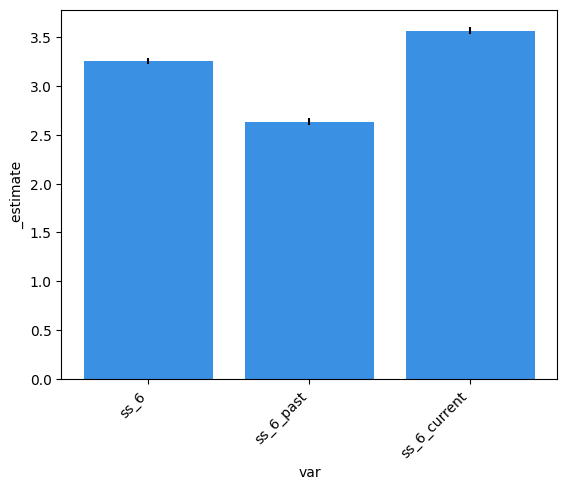

In [557]:
plot_df = sample_estimator_ss_6_df
plot_x_var = "var"

ax = sns.barplot(data=plot_df, x=plot_x_var, y="_estimate", color="dodgerblue", dodge=False)

#plt.draw()
ax.errorbar(data=plot_df, x=plot_x_var, y='_estimate', yerr=[plot_df["_estimate"] - plot_df["_lci"],plot_df["_uci"] - plot_df["_estimate"]], ls='', color='black')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

In [558]:
state_estimator_ss_6 = TaylorEstimator("mean")
state_estimator_ss_6.estimate(
    y=sub_df_1_as_oversample_states["stigma_scale_score"],
    samp_weight=sub_df_1_as_oversample_states["weight2"],
    stratum=sub_df_1_as_oversample_states["vstrat32_corrected"],
    psu=sub_df_1_as_oversample_states["vpsu32_corrected"],
    domain=sub_df_1_as_oversample_states["state_cd"]
)
#state_mean_estimates = state_estimator.to_dataframe().rename(columns={"_domain":"state_cd","_estimate":"mean"})

state_estimator_ss_6_df = state_estimator_ss_6.to_dataframe().rename(columns={"_domain":"state_cd"})


#sample_estimator_ss_6_current_df.insert(1,"_domain","nation")
state_estimator_ss_6_df.insert(0,"var","ss_6")
state_estimator_ss_6_df


,var,_param,state_cd,_estimate,_stderror,_lci,_uci,_cv
0,ss_6,mean,AZ,3.239992,0.051318,3.139330,3.340654,0.015839
1,ss_6,mean,CA,3.232257,0.057871,3.118742,3.345773,0.017904
2,ss_6,mean,CO,3.152531,0.047526,3.059308,3.245754,0.015075
3,ss_6,mean,CT,3.340636,0.048628,3.245251,3.436022,0.014557
4,ss_6,mean,DE,3.396479,0.090261,3.219430,3.573528,0.026575
5,ss_6,mean,FL,3.284171,0.053374,3.179476,3.388867,0.016252
6,ss_6,mean,GA,3.165353,0.046780,3.073593,3.257112,0.014779
7,ss_6,mean,HI,3.433506,0.068834,3.298487,3.568525,0.020048
8,ss_6,mean,IL,3.345380,0.054553,3.238373,3.452386,0.016307
9,ss_6,mean,IN,3.230767,0.032657,3.166709,3.294824,0.010108


In [559]:
state_estimator_ss_6_df.sort_values(by = ["_estimate"], inplace=True, ascending=True)

state_estimator_ss_6_df = state_estimator_ss_6_df\
    .merge(pop_counts_by_sampletypexstate,on='state_cd',how='left')

state_estimator_ss_6_df

,var,_param,state_cd,_estimate,_stderror,_lci,_uci,_cv,AS oversample,Gen pop,total,jcoin_hub_types,jcoin_hub_count,jcoin_flag
0,ss_6,mean,RI,2.990124,0.103447,2.787209,3.193038,0.034596,50,3,53,Brown(Linkage),1,1
1,ss_6,mean,WI,3.148575,0.057728,3.035340,3.261810,0.018335,232,38,270,non JCOIN gen pop,0,0
2,ss_6,mean,CO,3.152531,0.047526,3.059308,3.245754,0.015075,229,33,262,non JCOIN comparison,0,0
3,ss_6,mean,LA,3.159445,0.073089,3.016078,3.302811,0.023134,166,11,177,non JCOIN gen pop,0,0
4,ss_6,mean,GA,3.165353,0.046780,3.073593,3.257112,0.014779,232,26,258,non JCOIN gen pop,0,0
5,ss_6,mean,MD,3.186235,0.047558,3.092949,3.279521,0.014926,228,15,243,Friends(Linkage),1,1
6,ss_6,mean,NC,3.198084,0.054288,3.091597,3.304571,0.016975,244,38,282,"Yale - TCN(Linkage),Brown(Linkage)",2,1
7,ss_6,mean,KY,3.218846,0.064783,3.091774,3.345919,0.020126,199,23,222,UKY(Linkage),1,1
8,ss_6,mean,IN,3.230767,0.032657,3.166709,3.294824,0.010108,263,34,297,Indiana(Linkage),1,1
9,ss_6,mean,CA,3.232257,0.057871,3.118742,3.345773,0.017904,258,119,377,non JCOIN gen pop,0,0


[Text(0, 0, 'RI'),
 Text(1, 0, 'WI'),
 Text(2, 0, 'CO'),
 Text(3, 0, 'LA'),
 Text(4, 0, 'GA'),
 Text(5, 0, 'MD'),
 Text(6, 0, 'NC'),
 Text(7, 0, 'KY'),
 Text(8, 0, 'IN'),
 Text(9, 0, 'CA'),
 Text(10, 0, 'VA'),
 Text(11, 0, 'AZ'),
 Text(12, 0, 'MA'),
 Text(13, 0, 'NJ'),
 Text(14, 0, 'WA'),
 Text(15, 0, 'FL'),
 Text(16, 0, 'OR'),
 Text(17, 0, 'NH'),
 Text(18, 0, 'MN'),
 Text(19, 0, 'TX'),
 Text(20, 0, 'PA'),
 Text(21, 0, 'NY'),
 Text(22, 0, 'CT'),
 Text(23, 0, 'IL'),
 Text(24, 0, 'NM'),
 Text(25, 0, 'DE'),
 Text(26, 0, 'HI')]

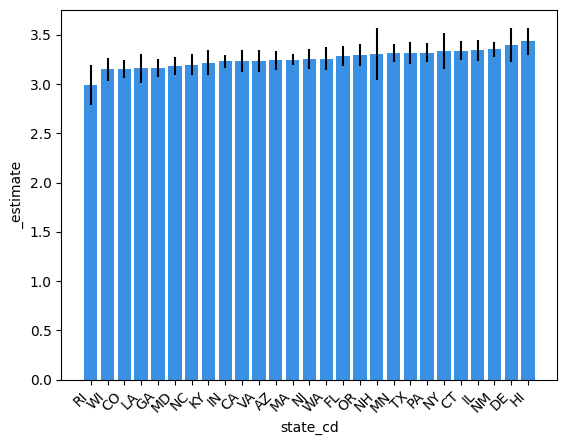

In [560]:
plot_df = state_estimator_ss_6_df
plot_x_var = "state_cd"

ax = sns.barplot(data=plot_df, x=plot_x_var, y="_estimate", color="dodgerblue", dodge=False)

#plt.draw()
ax.errorbar(data=plot_df, x=plot_x_var, y='_estimate', yerr=[plot_df["_estimate"] - plot_df["_lci"],plot_df["_uci"] - plot_df["_estimate"]], ls='', color='black')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

[Text(0, 0, 'RI'),
 Text(1, 0, 'WI'),
 Text(2, 0, 'CO'),
 Text(3, 0, 'LA'),
 Text(4, 0, 'GA'),
 Text(5, 0, 'MD'),
 Text(6, 0, 'NC'),
 Text(7, 0, 'KY'),
 Text(8, 0, 'IN'),
 Text(9, 0, 'CA'),
 Text(10, 0, 'VA'),
 Text(11, 0, 'AZ'),
 Text(12, 0, 'MA'),
 Text(13, 0, 'NJ'),
 Text(14, 0, 'WA'),
 Text(15, 0, 'FL'),
 Text(16, 0, 'OR'),
 Text(17, 0, 'NH'),
 Text(18, 0, 'MN'),
 Text(19, 0, 'TX'),
 Text(20, 0, 'PA'),
 Text(21, 0, 'NY'),
 Text(22, 0, 'CT'),
 Text(23, 0, 'IL'),
 Text(24, 0, 'NM'),
 Text(25, 0, 'DE'),
 Text(26, 0, 'HI')]

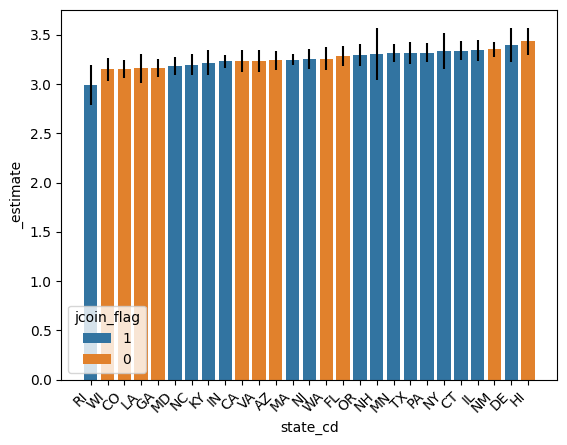

In [561]:
plot_df = state_estimator_ss_6_df
plot_x_var = "state_cd"
plot_color_by_var = "jcoin_flag"

ax = sns.barplot(data=plot_df, x=plot_x_var, y="_estimate", dodge=False, hue=plot_df[plot_color_by_var].astype("string"))

#plt.draw()
ax.errorbar(data=plot_df, x=plot_x_var, y='_estimate', yerr=[plot_df["_estimate"] - plot_df["_lci"],plot_df["_uci"] - plot_df["_estimate"]], ls='', color='black')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

In [562]:
state_estimator_ss_6_past = TaylorEstimator("mean")
state_estimator_ss_6_past.estimate(
    y=sub_df_1_as_oversample_states["ss_6_past"],
    samp_weight=sub_df_1_as_oversample_states["weight2"],
    stratum=sub_df_1_as_oversample_states["vstrat32_corrected"],
    psu=sub_df_1_as_oversample_states["vpsu32_corrected"],
    domain=sub_df_1_as_oversample_states["state_cd"]
)
#state_mean_estimates = state_estimator.to_dataframe().rename(columns={"_domain":"state_cd","_estimate":"mean"})

state_estimator_ss_6_past_df = state_estimator_ss_6_past.to_dataframe().rename(columns={"_domain":"state_cd"})


#sample_estimator_ss_6_current_df.insert(1,"_domain","nation")
state_estimator_ss_6_past_df.insert(0,"var","ss_6_past")
state_estimator_ss_6_past_df

,var,_param,state_cd,_estimate,_stderror,_lci,_uci,_cv
0,ss_6_past,mean,AZ,2.493573,0.067385,2.361395,2.625751,0.027024
1,ss_6_past,mean,CA,2.626626,0.052356,2.523930,2.729323,0.019933
2,ss_6_past,mean,CO,2.480545,0.060643,2.361592,2.599498,0.024448
3,ss_6_past,mean,CT,2.710022,0.093176,2.527255,2.892789,0.034382
4,ss_6_past,mean,DE,2.722410,0.135130,2.457350,2.987471,0.049636
5,ss_6_past,mean,FL,2.755736,0.057436,2.643074,2.868399,0.020842
6,ss_6_past,mean,GA,2.618951,0.075311,2.471226,2.766676,0.028756
7,ss_6_past,mean,HI,2.784069,0.078058,2.630956,2.937182,0.028037
8,ss_6_past,mean,IL,2.698470,0.091583,2.518828,2.878113,0.033939
9,ss_6_past,mean,IN,2.602682,0.054311,2.496150,2.709214,0.020867


In [563]:
# order state by same order as when sorting by ss_6
state_order_by_ss_6 = list(state_estimator_ss_6_df["state_cd"])
state_order_by_ss_6

state_estimator_ss_6_past_df = state_estimator_ss_6_past_df.iloc[state_estimator_ss_6_past_df["state_cd"].map({v: k for k, v in enumerate(state_order_by_ss_6)}).argsort()]


state_estimator_ss_6_past_df = state_estimator_ss_6_past_df\
    .merge(pop_counts_by_sampletypexstate,on='state_cd',how='left')

state_estimator_ss_6_past_df


,var,_param,state_cd,_estimate,_stderror,_lci,_uci,_cv,AS oversample,Gen pop,total,jcoin_hub_types,jcoin_hub_count,jcoin_flag
0,ss_6_past,mean,RI,2.345862,0.147684,2.056175,2.635548,0.062955,50,3,53,Brown(Linkage),1,1
1,ss_6_past,mean,WI,2.490951,0.079677,2.334663,2.647240,0.031987,232,38,270,non JCOIN gen pop,0,0
2,ss_6_past,mean,CO,2.480545,0.060643,2.361592,2.599498,0.024448,229,33,262,non JCOIN comparison,0,0
3,ss_6_past,mean,LA,2.649273,0.097816,2.457404,2.841143,0.036922,166,11,177,non JCOIN gen pop,0,0
4,ss_6_past,mean,GA,2.618951,0.075311,2.471226,2.766676,0.028756,232,26,258,non JCOIN gen pop,0,0
5,ss_6_past,mean,MD,2.471445,0.053383,2.366734,2.576157,0.021600,228,15,243,Friends(Linkage),1,1
6,ss_6_past,mean,NC,2.661672,0.081731,2.501355,2.821989,0.030707,244,38,282,"Yale - TCN(Linkage),Brown(Linkage)",2,1
7,ss_6_past,mean,KY,2.549583,0.076544,2.399441,2.699726,0.030022,199,23,222,UKY(Linkage),1,1
8,ss_6_past,mean,IN,2.602682,0.054311,2.496150,2.709214,0.020867,263,34,297,Indiana(Linkage),1,1
9,ss_6_past,mean,CA,2.626626,0.052356,2.523930,2.729323,0.019933,258,119,377,non JCOIN gen pop,0,0


In [564]:
state_estimator_ss_6_current = TaylorEstimator("mean")
state_estimator_ss_6_current.estimate(
    y=sub_df_1_as_oversample_states["ss_6_current"],
    samp_weight=sub_df_1_as_oversample_states["weight2"],
    stratum=sub_df_1_as_oversample_states["vstrat32_corrected"],
    psu=sub_df_1_as_oversample_states["vpsu32_corrected"],
    domain=sub_df_1_as_oversample_states["state_cd"]
)
#state_mean_estimates = state_estimator.to_dataframe().rename(columns={"_domain":"state_cd","_estimate":"mean"})

state_estimator_ss_6_current_df = state_estimator_ss_6_current.to_dataframe().rename(columns={"_domain":"state_cd"})


#sample_estimator_ss_6_current_df.insert(1,"_domain","nation")
state_estimator_ss_6_current_df.insert(0,"var","ss_6_current")
state_estimator_ss_6_current_df

,var,_param,state_cd,_estimate,_stderror,_lci,_uci,_cv
0,ss_6_current,mean,AZ,3.602810,0.052371,3.500084,3.705536,0.014536
1,ss_6_current,mean,CA,3.532810,0.065943,3.403461,3.662158,0.018666
2,ss_6_current,mean,CO,3.485571,0.053931,3.379783,3.591359,0.015473
3,ss_6_current,mean,CT,3.644447,0.057266,3.532117,3.756776,0.015713
4,ss_6_current,mean,DE,3.737822,0.088125,3.564962,3.910681,0.023577
5,ss_6_current,mean,FL,3.545219,0.064012,3.419657,3.670781,0.018056
6,ss_6_current,mean,GA,3.438824,0.050166,3.340423,3.537225,0.014588
7,ss_6_current,mean,HI,3.740744,0.095767,3.552896,3.928593,0.025601
8,ss_6_current,mean,IL,3.673210,0.047042,3.580936,3.765483,0.012807
9,ss_6_current,mean,IN,3.544157,0.039505,3.466667,3.621648,0.011147


In [565]:
# order state by same order as when sorting by ss_6
state_order_by_ss_6 = list(state_estimator_ss_6_df["state_cd"])
state_order_by_ss_6

state_estimator_ss_6_current_df = state_estimator_ss_6_current_df.iloc[state_estimator_ss_6_current_df["state_cd"].map({v: k for k, v in enumerate(state_order_by_ss_6)}).argsort()]


state_estimator_ss_6_current_df = state_estimator_ss_6_current_df\
    .merge(pop_counts_by_sampletypexstate,on='state_cd',how='left')

state_estimator_ss_6_current_df

,var,_param,state_cd,_estimate,_stderror,_lci,_uci,_cv,AS oversample,Gen pop,total,jcoin_hub_types,jcoin_hub_count,jcoin_flag
0,ss_6_current,mean,RI,3.312255,0.115950,3.084816,3.539693,0.035006,50,3,53,Brown(Linkage),1,1
1,ss_6_current,mean,WI,3.470024,0.059368,3.353573,3.586475,0.017109,232,38,270,non JCOIN gen pop,0,0
2,ss_6_current,mean,CO,3.485571,0.053931,3.379783,3.591359,0.015473,229,33,262,non JCOIN comparison,0,0
3,ss_6_current,mean,LA,3.415293,0.067658,3.282579,3.548007,0.019810,166,11,177,non JCOIN gen pop,0,0
4,ss_6_current,mean,GA,3.438824,0.050166,3.340423,3.537225,0.014588,232,26,258,non JCOIN gen pop,0,0
5,ss_6_current,mean,MD,3.549277,0.049648,3.451892,3.646663,0.013988,228,15,243,Friends(Linkage),1,1
6,ss_6_current,mean,NC,3.470710,0.043158,3.386054,3.555367,0.012435,244,38,282,"Yale - TCN(Linkage),Brown(Linkage)",2,1
7,ss_6_current,mean,KY,3.551461,0.064479,3.424983,3.677939,0.018156,199,23,222,UKY(Linkage),1,1
8,ss_6_current,mean,IN,3.544157,0.039505,3.466667,3.621648,0.011147,263,34,297,Indiana(Linkage),1,1
9,ss_6_current,mean,CA,3.532810,0.065943,3.403461,3.662158,0.018666,258,119,377,non JCOIN gen pop,0,0


In [566]:
state_estimator_ss_6_df = pd.concat([state_estimator_ss_6_df,state_estimator_ss_6_past_df,state_estimator_ss_6_current_df], axis = 0)


In [567]:


## order ss_6 vars
#ss_6_var_order = ["ss_6_current","ss_6","ss_6_past"]
#state_estimator_ss_6_df = state_estimator_ss_6_df.iloc[state_estimator_ss_6_df["var"].map({v: k for k, v in enumerate(ss_6_var_order)}).argsort()]

# order state by same order as when sorting by ss_6
state_order_by_ss_6 = list(state_estimator_ss_6_df["state_cd"])
state_order_by_ss_6

state_estimator_ss_6_df = state_estimator_ss_6_df.iloc[state_estimator_ss_6_df["state_cd"].map({v: k for k, v in enumerate(state_order_by_ss_6)}).argsort()]


state_estimator_ss_6_df

,var,_param,state_cd,_estimate,_stderror,_lci,_uci,_cv,AS oversample,Gen pop,total,jcoin_hub_types,jcoin_hub_count,jcoin_flag
0,ss_6,mean,RI,2.990124,0.103447,2.787209,3.193038,0.034596,50,3,53,Brown(Linkage),1,1
0,ss_6_current,mean,RI,3.312255,0.115950,3.084816,3.539693,0.035006,50,3,53,Brown(Linkage),1,1
0,ss_6_past,mean,RI,2.345862,0.147684,2.056175,2.635548,0.062955,50,3,53,Brown(Linkage),1,1
1,ss_6,mean,WI,3.148575,0.057728,3.035340,3.261810,0.018335,232,38,270,non JCOIN gen pop,0,0
1,ss_6_current,mean,WI,3.470024,0.059368,3.353573,3.586475,0.017109,232,38,270,non JCOIN gen pop,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,ss_6_past,mean,DE,2.722410,0.135130,2.457350,2.987471,0.049636,101,6,107,NYU(MOUD comparative effectiveness),1,1
25,ss_6,mean,DE,3.396479,0.090261,3.219430,3.573528,0.026575,101,6,107,NYU(MOUD comparative effectiveness),1,1
26,ss_6_past,mean,HI,2.784069,0.078058,2.630956,2.937182,0.028037,67,2,69,non JCOIN comparison,0,0
26,ss_6,mean,HI,3.433506,0.068834,3.298487,3.568525,0.020048,67,2,69,non JCOIN comparison,0,0


[Text(0, 0, 'RI'),
 Text(1, 0, 'WI'),
 Text(2, 0, 'CO'),
 Text(3, 0, 'LA'),
 Text(4, 0, 'GA'),
 Text(5, 0, 'MD'),
 Text(6, 0, 'NC'),
 Text(7, 0, 'KY'),
 Text(8, 0, 'IN'),
 Text(9, 0, 'CA'),
 Text(10, 0, 'VA'),
 Text(11, 0, 'AZ'),
 Text(12, 0, 'MA'),
 Text(13, 0, 'NJ'),
 Text(14, 0, 'WA'),
 Text(15, 0, 'FL'),
 Text(16, 0, 'OR'),
 Text(17, 0, 'NH'),
 Text(18, 0, 'MN'),
 Text(19, 0, 'TX'),
 Text(20, 0, 'PA'),
 Text(21, 0, 'NY'),
 Text(22, 0, 'CT'),
 Text(23, 0, 'IL'),
 Text(24, 0, 'NM'),
 Text(25, 0, 'DE'),
 Text(26, 0, 'HI')]

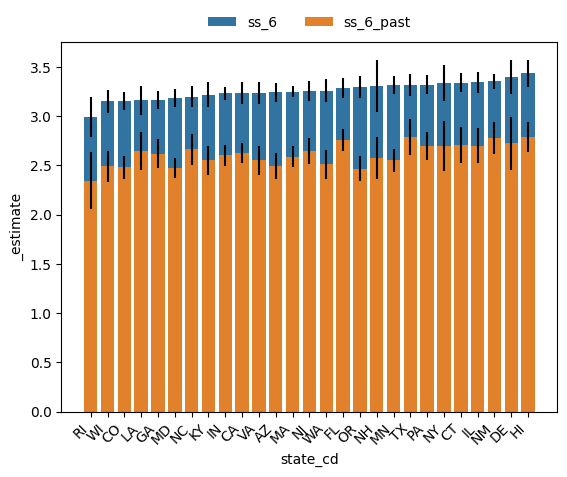

In [572]:
plot_df = state_estimator_ss_6_df[state_estimator_ss_6_df["var"].isin(["ss_6","ss_6_past"])]
plot_x_var = "state_cd"
plot_color_by_var = "var"

ax = sns.barplot(data=plot_df, x=plot_x_var, y="_estimate", dodge=False, hue=plot_df[plot_color_by_var].astype("string"))
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
#plt.draw()
ax.errorbar(data=plot_df, x=plot_x_var, y='_estimate', yerr=[plot_df["_estimate"] - plot_df["_lci"],plot_df["_uci"] - plot_df["_estimate"]], ls='', color='black')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

[Text(0, 0, 'RI'),
 Text(1, 0, 'WI'),
 Text(2, 0, 'CO'),
 Text(3, 0, 'LA'),
 Text(4, 0, 'GA'),
 Text(5, 0, 'MD'),
 Text(6, 0, 'NC'),
 Text(7, 0, 'KY'),
 Text(8, 0, 'IN'),
 Text(9, 0, 'CA'),
 Text(10, 0, 'VA'),
 Text(11, 0, 'AZ'),
 Text(12, 0, 'MA'),
 Text(13, 0, 'NJ'),
 Text(14, 0, 'WA'),
 Text(15, 0, 'FL'),
 Text(16, 0, 'OR'),
 Text(17, 0, 'NH'),
 Text(18, 0, 'MN'),
 Text(19, 0, 'TX'),
 Text(20, 0, 'PA'),
 Text(21, 0, 'NY'),
 Text(22, 0, 'CT'),
 Text(23, 0, 'IL'),
 Text(24, 0, 'NM'),
 Text(25, 0, 'DE'),
 Text(26, 0, 'HI')]

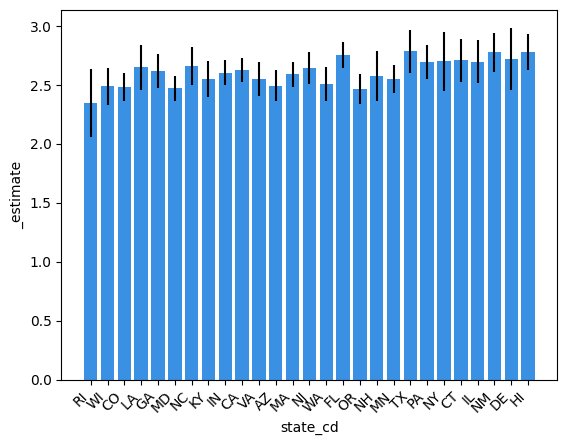

In [573]:
plot_df = state_estimator_ss_6_df[state_estimator_ss_6_df["var"].isin(["ss_6_past"])]
plot_x_var = "state_cd"

ax = sns.barplot(data=plot_df, x=plot_x_var, y="_estimate", color="dodgerblue", dodge=False)

#plt.draw()
ax.errorbar(data=plot_df, x=plot_x_var, y='_estimate', yerr=[plot_df["_estimate"] - plot_df["_lci"],plot_df["_uci"] - plot_df["_estimate"]], ls='', color='black')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

[Text(0, 0, 'RI'),
 Text(1, 0, 'WI'),
 Text(2, 0, 'CO'),
 Text(3, 0, 'LA'),
 Text(4, 0, 'GA'),
 Text(5, 0, 'MD'),
 Text(6, 0, 'NC'),
 Text(7, 0, 'KY'),
 Text(8, 0, 'IN'),
 Text(9, 0, 'CA'),
 Text(10, 0, 'VA'),
 Text(11, 0, 'AZ'),
 Text(12, 0, 'MA'),
 Text(13, 0, 'NJ'),
 Text(14, 0, 'WA'),
 Text(15, 0, 'FL'),
 Text(16, 0, 'OR'),
 Text(17, 0, 'NH'),
 Text(18, 0, 'MN'),
 Text(19, 0, 'TX'),
 Text(20, 0, 'PA'),
 Text(21, 0, 'NY'),
 Text(22, 0, 'CT'),
 Text(23, 0, 'IL'),
 Text(24, 0, 'NM'),
 Text(25, 0, 'DE'),
 Text(26, 0, 'HI')]

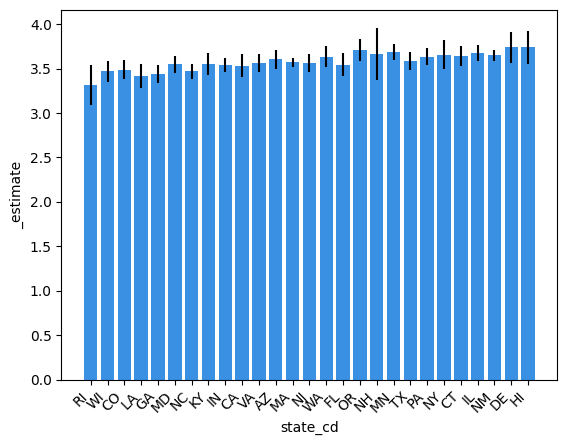

In [574]:
plot_df = state_estimator_ss_6_df[state_estimator_ss_6_df["var"].isin(["ss_6_current"])]
plot_x_var = "state_cd"

ax = sns.barplot(data=plot_df, x=plot_x_var, y="_estimate", color="dodgerblue", dodge=False)

#plt.draw()
ax.errorbar(data=plot_df, x=plot_x_var, y='_estimate', yerr=[plot_df["_estimate"] - plot_df["_lci"],plot_df["_uci"] - plot_df["_estimate"]], ls='', color='black')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

In [89]:
party_d_estimator = TaylorEstimator("mean")
party_d_estimator.estimate(
    y=sub_df_1["stigma_scale_score"],
    samp_weight=sub_df_1["weight2"],
    stratum=sub_df_1["vstrat32_corrected"],
    psu=sub_df_1["vpsu32_corrected"],
    domain=sub_df_1["partyid5_strong_d"]
)


party_d_estimates = party_d_estimator.to_dataframe().rename(columns={"_domain":"party_d","_estimate":"mean"})

party_r_estimator = TaylorEstimator("mean")
party_r_estimator.estimate(
    y=sub_df_1["stigma_scale_score"],
    samp_weight=sub_df_1["weight2"],
    stratum=sub_df_1["vstrat32_corrected"],
    psu=sub_df_1["vpsu32_corrected"],
    domain=sub_df_1["partyid5_strong_r"]
)


party_d_estimates = party_d_estimator.to_dataframe().rename(columns={"_domain":"party_d","_estimate":"mean"})

party_r_estimates = party_r_estimator.to_dataframe().rename(columns={"_domain":"party_r","_estimate":"mean"})

In [93]:
party_d_estimates

,_param,party_d,mean,_stderror,_lci,_uci,_cv
0,mean,0,3.308520,0.019874,3.269538,3.347502,0.006007
1,mean,1,3.148911,0.024726,3.100411,3.197410,0.007852


In [90]:
party_r_estimates

,_param,party_r,mean,_stderror,_lci,_uci,_cv
0,mean,0,3.184258,0.019837,3.145348,3.223167,0.006230
1,mean,1,3.469316,0.032018,3.406513,3.532118,0.009229


In [94]:
#'race_whiteadvantage', 'race_rich'

race_views_1_estimator = TaylorEstimator("mean")
race_views_1_estimator.estimate(
    y=sub_df_1["stigma_scale_score"],
    samp_weight=sub_df_1["weight2"],
    stratum=sub_df_1["vstrat32_corrected"],
    psu=sub_df_1["vpsu32_corrected"],
    domain=sub_df_1["race_whiteadvantage"]
)


race_views_1_estimates = race_views_1_estimator.to_dataframe().rename(columns={"_domain":"race_views_1","_estimate":"mean"})

race_views_2_estimator = TaylorEstimator("mean")
race_views_2_estimator.estimate(
    y=sub_df_1["stigma_scale_score"],
    samp_weight=sub_df_1["weight2"],
    stratum=sub_df_1["vstrat32_corrected"],
    psu=sub_df_1["vpsu32_corrected"],
    domain=sub_df_1["race_rich"]
)


race_views_2_estimates = race_views_2_estimator.to_dataframe().rename(columns={"_domain":"race_views_2","_estimate":"mean"})

In [95]:
race_views_1_estimates

,_param,race_views_1,mean,_stderror,_lci,_uci,_cv
0,mean,1.0,3.120033,0.031283,3.058673,3.181394,0.010026
1,mean,2.0,3.272321,0.029655,3.214153,3.330488,0.009062
2,mean,3.0,3.246482,0.040486,3.167070,3.325895,0.012471
3,mean,4.0,3.347806,0.032672,3.283721,3.411890,0.009759
4,mean,5.0,3.461622,0.041794,3.379644,3.543601,0.012074


In [96]:
race_views_2_estimates

,_param,race_views_2,mean,_stderror,_lci,_uci,_cv
0,mean,1.0,2.981580,0.049307,2.884866,3.078294,0.016537
1,mean,2.0,3.196050,0.030071,3.137067,3.255032,0.009409
2,mean,3.0,3.172122,0.037136,3.099280,3.244964,0.011707
3,mean,4.0,3.345893,0.028685,3.289628,3.402157,0.008573
4,mean,5.0,3.424981,0.030702,3.364760,3.485203,0.008964


In [245]:
# quick map of state level estimates

fig = px.choropleth(state_mean_estimates,
    locations="state_cd",
    locationmode="USA-states",
    scope="usa",
    color="mean",
    color_continuous_scale="Viridis_r")

fig.show()


In [ ]:
# merge jcoin info
state_mean_estimates = state_mean_estimates\
    .merge(jcoin_df,on='state_cd',how='left')\
    .sort_values("mean",ascending=False)\
    .assign(
        jcoin_hub_count=lambda df:df.jcoin_hub_count.fillna(0).astype(int),
        jcoin_flag=lambda df:df.jcoin_flag.fillna(0).astype(int))

state_mean_estimates["jcoin_color"] = state_mean_estimates.jcoin_flag
state_mean_estimates.jcoin_color.replace({0:"blue",1:"red"},inplace=True)


state_mean_estimates.head()

```{margin} 
**To go to the data/study page on the HEAL Data Platform, follow this link:** my link
```

```{margin} 
**To go to an interactive analytic cloud workspace with the analysis code and data loaded, follow this link:** my link
```

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Sodales ut eu sem integer vitae justo eget. Pellentesque dignissim enim sit amet venenatis urna cursus. Sed faucibus turpis in eu mi bibendum. Scelerisque felis imperdiet proin fermentum leo. Volutpat est velit egestas dui id ornare arcu. Quis lectus nulla at volutpat diam ut venenatis tellus. Tellus pellentesque eu tincidunt tortor aliquam nulla facilisi cras. Pellentesque adipiscing commodo elit at imperdiet dui. 
<br>

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Sodales ut eu sem integer vitae justo eget. Pellentesque dignissim enim sit amet venenatis urna cursus. Sed faucibus turpis in eu mi bibendum. Scelerisque felis imperdiet proin fermentum leo. Volutpat est velit egestas dui id ornare arcu. Quis lectus nulla at volutpat diam ut venenatis tellus. Tellus pellentesque eu tincidunt tortor aliquam nulla facilisi cras. Pellentesque adipiscing commodo elit at imperdiet dui. 
<br><br>
In hac habitasse platea dictumst quisque sagittis purus. Libero volutpat sed cras ornare. Sit amet consectetur adipiscing elit pellentesque habitant morbi tristique senectus. Auctor augue mauris augue neque gravida in fermentum et. Amet mattis vulputate enim nulla aliquet porttitor. Proin sed libero enim sed faucibus turpis in eu. Morbi tristique senectus et netus et malesuada. Feugiat sed lectus vestibulum mattis ullamcorper.

**Data Citation** 
<br>
Harold Pollack, Johnathon Schneider, Bruce Taylor. JCOIN 026: Brief Stigma Survey. Chicago, IL: Center for Translational Data Science HEAL Data Platform (distributor) via Center for Translational Data Science JCOIN Data Commons (repository & distributor), 2022-04-08. (HEAL Data Platform branded doi goes here)
<br>
**Brief Article Citation** 
<br>
What format should this be? 